In [46]:
1384.497297/0.1 * 100/3600/24

16.02427427083333

In [1]:
using Distributed
cpuNum = length(Sys.cpu_info()) 
# number of cpu cores

addprocs(cpuNum - 2)
# using all cpu cores

@everywhere using HCubature
using PyPlot
using BenchmarkTools
using DelimitedFiles:readdlm

In [2]:
@everywhere xi0, theta0, phi0 = pi/5, pi/3, pi/4
@everywhere L10, L20, f0 = 100, 100, 1/10 
@everywhere rTol = 1e-4 # relative torelance for integration
@everywhere polars = ["TT", "ST", "VL", "SL"]

In [3]:
@everywhere function e_factor(xi, L1, L2, f, theta, phi)
    phase1 = 2im*f*L1*pi*(1.0 + cos(theta))
    phase2 = -2im*f*L2*pi*(1.0 + cos(theta)*cos(xi) + cos(phi)*sin(theta)*sin(xi))
    temp1 = -1.0 + exp(phase1)
    temp2 = -1.0 + exp(phase2)
    real(temp1*temp2)
end

@time e_factor(xi0, L10, L20, 100, theta0, phi0)

  0.161833 seconds (546.89 k allocations: 26.230 MiB)


1.811449160776493e-13

In [4]:
@everywhere function Gamma(polar, xi, L1, L2, f; psrTerm=true)
    if polar == "TT"
        Gamma0 = GammaTT0
    elseif polar == "ST"
        Gamma0 = GammaST0
    elseif polar == "VL"
        Gamma0 = GammaVL0
    elseif polar == "SL"
        Gamma0 = GammaSL0
    end
    if psrTerm
        integral = x -> Gamma0(xi, x[1], x[2])*e_factor(xi, L1, L2, f, x[1], x[2])
    else
        integral = x -> Gamma0(xi, x[1], x[2])
    end
    hcubature(integral, [0.0, 0.0], [pi, 2pi], rtol=1e-4, maxevals=10^8, initdiv=2)[1]
end

In [5]:
function Gammas(polar, xi, L1, L2, fs; psrTerm=true)
    pmap(f -> Gamma(polar, xi, L1, L2, f, psrTerm=psrTerm), fs)
end

Gammas (generic function with 1 method)

## TT (+&×) Polarization

In [6]:
@everywhere function GammaTT0(xi, theta, phi)
    return 3.0/8.0/pi * (sin(theta/2.0)^2.0 * sin(theta) * (
        (cos(xi)*sin(theta) - cos(theta)*cos(phi)*sin(xi))^2.0 
        - sin(xi)^2.0 * sin(phi)^2.0)
     )/(1.0 + cos(theta)*cos(xi) + cos(phi)*sin(theta)*sin(xi))
end


@time GammaTT0(xi0, theta0, phi0)

  0.014882 seconds (34.91 k allocations: 1.869 MiB)


0.0010270566287711445

In [7]:
@time Gamma("TT", pi/2.0, L10, L20, f0)

  3.224752 seconds (14.15 M allocations: 534.615 MiB, 3.96% gc time)


-0.2864664111078491

In [8]:
# Analytical version of GammaTT
function GammaTTA(xi, L1, L2, f)
    k = (1.0-cos(xi))/2.0
    return 3.0*(1.0/3.0 + k*(log(k)-1.0/6.0))
end

@time GammaTTA(pi/3, L10, L20, f0)

  0.004554 seconds (3.89 k allocations: 221.251 KiB)


-0.16472077083991787

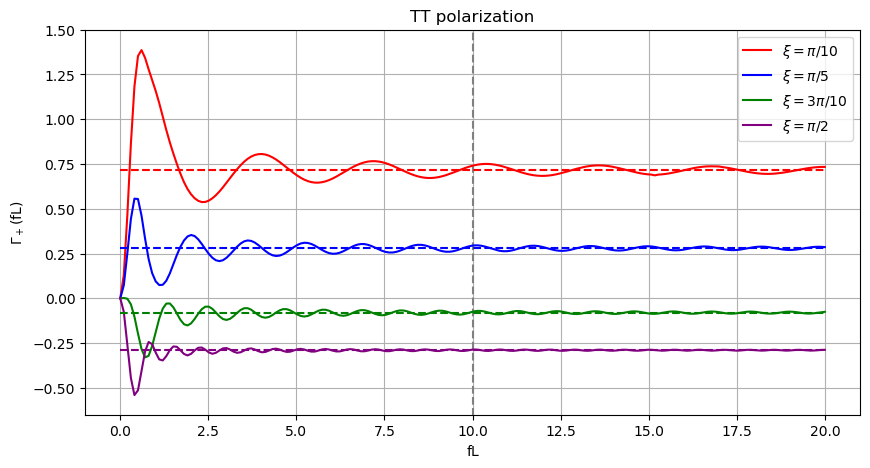

 71.532540 seconds (145.87 k allocations: 4.937 MiB)


In [10]:
@time begin
fs = range(0, 20, length=200)
Gammas1 = Gammas("TT", pi/10, 1, 1, fs)
Gammas2 = Gammas("TT", pi/5, 1, 1, fs)
Gammas3 = Gammas("TT", 3pi/10, 1, 1, fs)
Gammas4 = Gammas("TT", pi/2, 1, 1, fs)

Gammas5 = Gammas("TT", pi/10, 1, 1, fs, psrTerm=false)
Gammas6 = Gammas("TT", pi/5, 1, 1, fs, psrTerm=false)
Gammas7 = Gammas("TT", 3pi/10, 1, 1, fs, psrTerm=false)
Gammas8 = Gammas("TT", pi/2, 1, 1, fs, psrTerm=false)

figure(figsize=(10, 5))
plot(fs, Gammas1, "red", label=L"$\xi=\pi/10$")
plot(fs, Gammas2, "b", label=L"$\xi=\pi/5$")
plot(fs, Gammas3, "g", label=L"$\xi=3\pi/10$")
plot(fs, Gammas4, "purple", label=L"$\xi=\pi/2$")
plot(fs, Gammas5, "r--")
plot(fs, Gammas6, "b--")
plot(fs, Gammas7, "g--")
plot(fs, Gammas8, "--", color="purple")

xlabel("fL")
ylabel(L"$\Gamma_+$(fL)")
title("TT polarization")
ylim(-0.65, 1.5)
vlines(10, ymin=-1e3, ymax=1e3, linestyles="--", colors="gray")
grid("on")
tick_params(which="minor")
legend()
show()
end

## ST (b) Polarization

In [9]:
@everywhere function GammaST0(xi, theta, phi)
    return -3.0/8.0/pi * (sin(theta/2.0))^2.0 * sin(theta) * (
        -1 + cos(theta)*cos(xi) + cos(phi)*sin(theta)*sin(xi)
    )
end
GammaST0(xi0, theta0, phi0)

0.006087395043300234

In [10]:
@time Gamma("ST", xi0, L10, L20, f0)

  0.118715 seconds (2.50 M allocations: 52.367 MiB, 4.26% gc time)


0.9672451264844306

In [11]:
# Analytical version of GammaST
function GammaSTA(xi, L1, L2, f)
    return 1/4 * (3 + cos(xi))
end

GammaSTA(xi0, L10, L20, f0)

0.9522542485937369

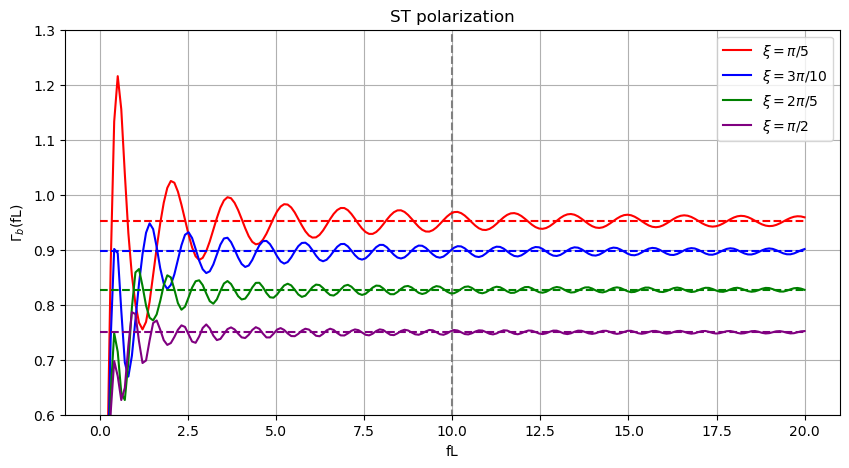

 58.254140 seconds (144.41 k allocations: 4.906 MiB)


In [15]:
@time begin
fs = range(0, 20, length=200)
Gammas1 = Gammas("ST", pi/5, 1, 1, fs)
Gammas2 = Gammas("ST", 3pi/10, 1, 1, fs)
Gammas3 = Gammas("ST", 2pi/5, 1, 1, fs)
Gammas4 = Gammas("ST", pi/2, 1, 1, fs)

Gammas5 = Gammas("ST", pi/5, 1, 1, fs, psrTerm=false)
Gammas6 = Gammas("ST", 3pi/10, 1, 1, fs, psrTerm=false)
Gammas7 = Gammas("ST", 2pi/5, 1, 1, fs, psrTerm=false)
Gammas8 = Gammas("ST", pi/2, 1, 1, fs, psrTerm=false)

figure(figsize=(10, 5))
plot(fs, Gammas1, "red", label=L"$\xi=\pi/5$")
plot(fs, Gammas2, "b", label=L"$\xi=3\pi/10$")
plot(fs, Gammas3, "g", label=L"$\xi=2\pi/5$")
plot(fs, Gammas4, "purple", label=L"$\xi=\pi/2$")
plot(fs, Gammas5, "r--")
plot(fs, Gammas6, "b--")
plot(fs, Gammas7, "g--")
plot(fs, Gammas8, "--", color="purple")

xlabel("fL")
ylabel(L"$\Gamma_b$(fL)")
title("ST polarization")
ylim(0.6, 1.3)
vlines(10, ymin=-1e3, ymax=1e3, linestyles="--", colors="gray")
grid("on")
legend()
show()
end

## VL (x&y) Polarization

In [12]:
@everywhere function GammaVL0(xi, theta, phi)
    return -3.0/8.0/pi * cos(theta) * sin(theta) * (
        sin(2.0*theta)*(-cos(xi)^2.0 + cos(phi)^2.0 * sin(xi)^2.0)
        + cos(2.0*theta) * cos(phi) * sin(2.0*xi) 
     )/(1.0 + cos(theta))/(cos(xi)*cos(theta)/sin(theta) + 1/sin(theta) + cos(phi)*sin(xi))
end

@time GammaVL0(0, pi/3, pi/4)

  0.017971 seconds (31.94 k allocations: 1.699 MiB)


0.017229027981931003

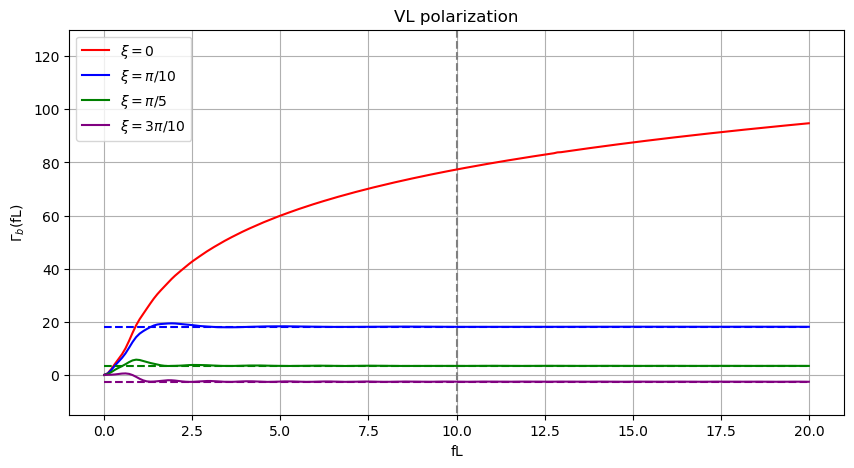

 30.347881 seconds (1.77 M allocations: 109.670 MiB, 0.06% gc time)


In [19]:
@time begin
fs = range(0, 20, length=200)
Gammas1 = 4*pi/3*Gammas("VL", 0, 1, 1, fs)
Gammas2 = 4*pi/3*Gammas("VL", pi/10, 1, 1, fs)
Gammas3 = 4*pi/3*Gammas("VL", pi/5, 1, 1, fs)
Gammas4 = 4*pi/3*Gammas("VL", 3pi/10, 1, 1, fs)

Gammas5 = 4*pi/3*Gammas("VL", 0, 1, 1, fs, psrTerm=false)
Gammas6 = 4*pi/3*Gammas("VL", pi/10, 1, 1, fs, psrTerm=false)
Gammas7 = 4*pi/3*Gammas("VL", pi/5, 1, 1, fs, psrTerm=false)
Gammas8 = 4*pi/3*Gammas("VL", 3pi/10, 1, 1, fs, psrTerm=false)

figure(figsize=(10, 5))
plot(fs, Gammas1, "red", label=L"$\xi=0$")
plot(fs, Gammas2, "b", label=L"$\xi=\pi/10$")
plot(fs, Gammas3, "g", label=L"$\xi=\pi/5$")
plot(fs, Gammas4, "purple", label=L"$\xi=3\pi/10$")
plot(fs, Gammas5, "r--")
plot(fs, Gammas6, "b--")
plot(fs, Gammas7, "g--")
plot(fs, Gammas8, "--", color="purple")

xlabel("fL")
ylabel(L"$\Gamma_b$(fL)")
title("VL polarization")
ylim(-15, 130)
vlines(10, ymin=-1e3, ymax=1e3, linestyles="--", colors="gray")
grid("on")
legend()
show()
end

## SL (l) Polarization

In [13]:
@everywhere function GammaSL0(xi, theta, phi)
    return 3.0/16.0/pi * cos(theta)^2.0 * sin(theta) * (
        cos(theta)*cos(xi) + cos(phi)*sin(theta)*sin(xi)
    )^2.0 /(1.0 + cos(theta))/(1 + cos(theta)*cos(xi) + cos(phi)*sin(theta)*sin(xi))
end

@time GammaSL0(xi0, pi/4,  pi/9)

  0.009296 seconds (18.76 k allocations: 1022.972 KiB)


0.005836080605476063

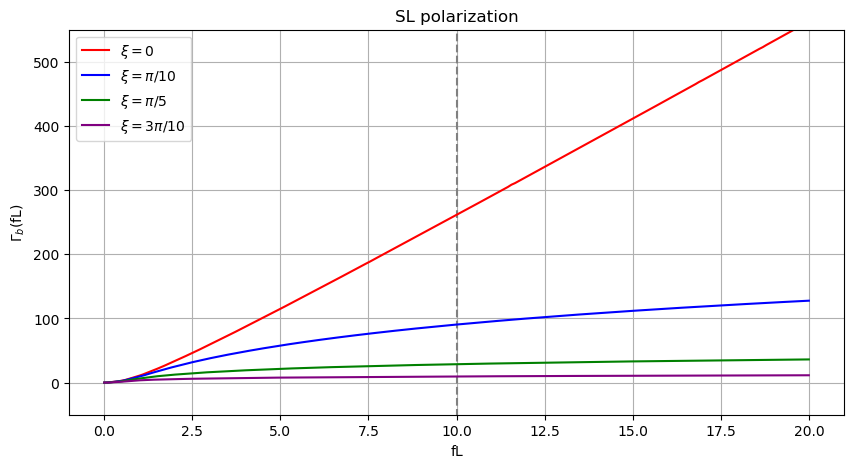

  8.260401 seconds (142.37 k allocations: 4.873 MiB)


In [50]:
@time begin
fs = range(0, 20, length=200)
Gammas1 = 4*pi/3*Gammas("SL", 0, 1, 1, fs)
Gammas2 = 4*pi/3*Gammas("SL", pi/10, 1, 1, fs)
Gammas3 = 4*pi/3*Gammas("SL", pi/5, 1, 1, fs)
Gammas4 = 4*pi/3*Gammas("SL", 3pi/10, 1, 1, fs)

Gammas5 = 4*pi/3*Gammas("SL", 0, 1, 1, fs, psrTerm=false)
Gammas6 = 4*pi/3*Gammas("SL", pi/10, 1, 1, fs, psrTerm=false)
Gammas7 = 4*pi/3*Gammas("SL", pi/5, 1, 1, fs, psrTerm=false)
Gammas8 = 4*pi/3*Gammas("SL", 3pi/10, 1, 1, fs, psrTerm=false)

figure(figsize=(10, 5))
plot(fs, Gammas1, "red", label=L"$\xi=0$")
plot(fs, Gammas2, "b", label=L"$\xi=\pi/10$")
plot(fs, Gammas3, "g", label=L"$\xi=\pi/5$")
plot(fs, Gammas4, "purple", label=L"$\xi=3\pi/10$")
plot(fs, Gammas5, "r--")
plot(fs, Gammas6, "b--")
plot(fs, Gammas7, "g--")
plot(fs, Gammas8, "--", color="purple")

xlabel("fL")
ylabel(L"$\Gamma_b$(fL)")
title("SL polarization")
ylim(-50, 550)
vlines(10, ymin=-1e3, ymax=1e3, linestyles="--", colors="gray")
grid("on")
legend()
show()
end

## Below

In [39]:
M2Data = readdlm("backup/prs_pair_info.txt");

In [40]:
xi, L1, L2 = M2Data[2,:];

In [73]:
L10 = L1 * kpc_to_sec
L20 = L2 * kpc_to_sec
@time Gs = Gammas("SL", xi, L10, L20, fs)

161.304575 seconds (638 allocations: 25.750 KiB)


6-element Array{Float64,1}:
 0.4687583932873618
 0.5249510044864218
 0.5397921742483501
 0.5531071081223736
 0.5543118551257618
 0.5553537322212189

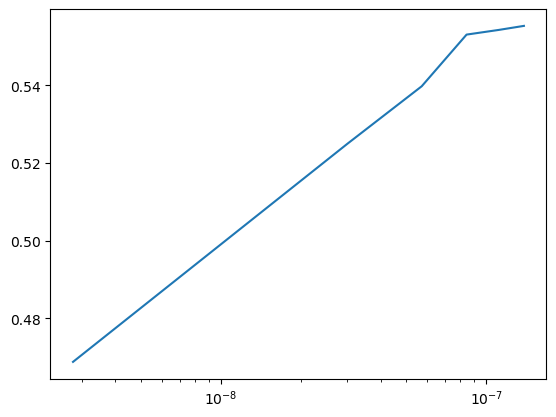

In [74]:
plot(fs, Gs)
xscale("log")
show()

In [41]:
function saveOnePair(polar, xi, L1, L2)
    nmode = 50 
    fmin = 2.774455633345974e-09
    fmax = nmode*fmin
    fs = range(fmin, fmax, length=6)
    file = string("backup/", polar, "_", xi, "_", L1, "_", L2, ".txt")
    
    yr = 365.25 * 24.0 * 3600.0
    kpc_to_sec = 3.26156e3 * yr
    L1 *= kpc_to_sec
    L2 *= kpc_to_sec
    Gs = Gammas(polar, xi, L1, L2, fs)
    open(file, "w") do io
        for i in 1:length(fs)
            write(io, string(fs[i]) * "  " * string(Gs[i]) * "\n")
        end
    end
end

xi, L1, L2 = M2Data[2,:]
@time saveOnePair("VL", xi, L1, L2)

130.500347 seconds (4.71 M allocations: 252.791 MiB, 0.02% gc time)


In [42]:
@time saveOnePair("SL", xi, L1, L2)

125.961832 seconds (4.60 k allocations: 137.719 KiB)


In [27]:
@time [Gamma(polar, 0, 1, 1, 20) for polar in polars]

  0.492775 seconds (1.15 M allocations: 66.189 MiB, 4.57% gc time)


4-element Array{Float64,1}:
   1.9998102227699146
   1.9998102227699146
  22.62468847763983  
 134.30116828587248  

In [23]:
@time Gamma("VL", pi/5, 3, 1, 20)

  1.217022 seconds (23.42 M allocations: 486.833 MiB, 4.07% gc time)


0.8495757829566705

In [86]:
@time saveOnePair("SL", xi, L1, L2)

126.626232 seconds (722 allocations: 30.344 KiB)


In [82]:
for i in 1:size(M2Data)[1]
    xi, L1, L2 = M2Data[i,:]
    saveOnePair("VL", xi, L1, L2)
end

22.22222222222222

In [43]:
300*210/3600

17.5

In [44]:
0 == 0.0

true